In [2]:
#General Framework of Time Series Forcasting (step by step)
#Step 1 — Check stationarity: jika data mengandung komponen trend atau seasonality 
               #maka data perlu ditransform terlbih dahulu agar stationer  
#Step 2 — Difference: jika data tidak stationer maka perlu di stationerkan melalui differencing.
               #Lakukan differencing pertama kemudian cek sudah stationer atau belum, jika belum maka lakukan differencing kedua dan seterusnya
#Step 3 — Filter out a validation sample: Ini digunakan untuk memvalidasi seberapa akurat model forecasting.
               #Gunakan train test validation split
#Step 4 — Select AR and MA terms: Gunakan Auto Correlation Function (ACF) and Partial ACF (PACF)
              #untuk menetukan harus memasukkan AR term(s), MA term(s), atau keduanya.
#Step 5 — Build the model: bangun model dan set beberapa periode untuk diprediksi 
#Step 6 — Validate model: Bandingkan hasil prediksi dengan nilai sebenarnya

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pylab as plt

In [8]:
#karena waktu masih format string maka perlu ditransformasi menjadi date
dateparse = lambda dates: pd.datetime.strptime(dates, "%Y-%m")
data = pd.read_csv("airline-passengers.csv", parse_dates = ['Month'],
                  index_col = 'Month', date_parser = dateparse)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


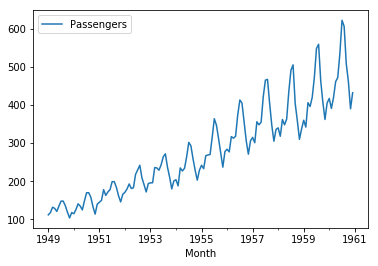

In [13]:
data.plot()
plt.show()

plot di atas menujukkan adanya trend menaik dengan variasi musiman

In [24]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Originial')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)

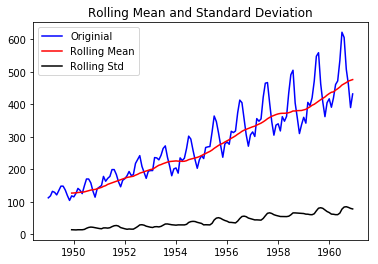

In [25]:
test_stationarity(data)

Stationarity didefinisikan dengan kriteria yang ketat. Data time series dikatakan stasioner jika memiliki bbrp komponen ini sepanjang waktu:
1. mean yang konstan
2. varians yang konstan
3. autocovariance yang tidak bergantung pada waktu

Data non-stationary dicirikan dengan adanya trend atau seasonal komponen.
* Trend -- mean yang berubah-ubah sepanjang waktu
* Seasonality -- variasi pada waktu-waktu tertentu, misal waktu bulan puasa, lebaran atau natal

In [28]:
def difference(dataset, interval = 1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["Passengers"][i] - dataset["Passengers"][i-interval]
        diff.append(value)
    return diff

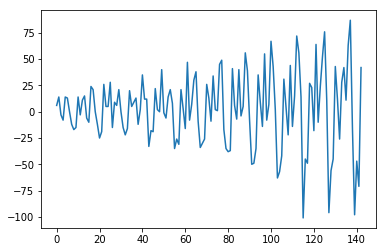

In [29]:
diff = difference(data)
plt.plot(diff)
plt.show()

hasil differencing pertama menunjukkan data masih memiliki trend menaik. 
#### Jadi kita harus mengaplikasikan transformasi jenis lain agar data menjadi stasioner.
Cara transformasi lain bisa dengan me-log kan, square root, cube root, dll.

<function matplotlib.pyplot.show(*args, **kw)>

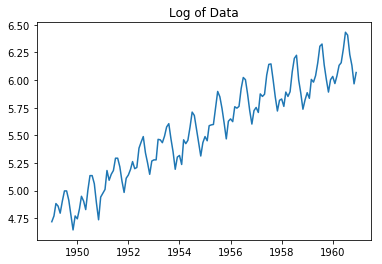

In [30]:
ts_log = np.log(data)
plt.title("Log of Data")
plt.plot(ts_log)
plt.show

### Moving Average
Dalam pendekatan ini, kita mengambil rata-rata dari 'k' nilai berurutan, misal nilai rata2 penumpang per tahun.

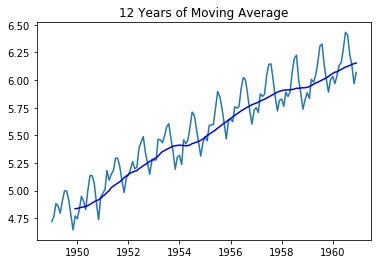

In [33]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.title('12 Years of Moving Average')
plt.plot(moving_avg, color='blue')
plt.show()

In [36]:
print(moving_avg.isnull().values.any())
print(moving_avg.isnull().sum().sum())

True
11


#### Eliminasi Trend dan Seasonality
Dua cara mengeliminasi trend dan seasonality:
1. Differencing - mengambil nilai selisih dengan time lag tertentu
2. Decomposition - modeling baik trend dan seasonality dan membuangnya dari model

### Differencing 

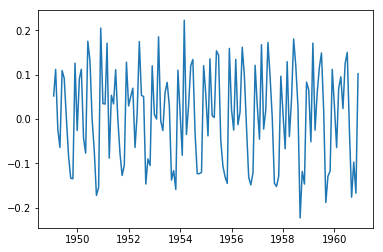

In [44]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

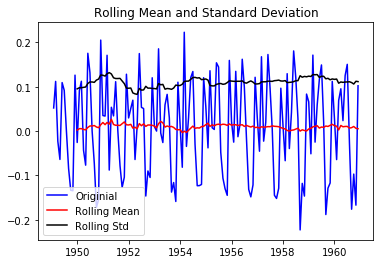

In [45]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposition

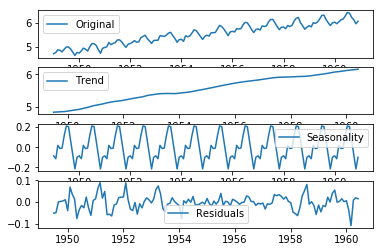

<Figure size 432x288 with 0 Axes>

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.show()
plt.tight_layout()

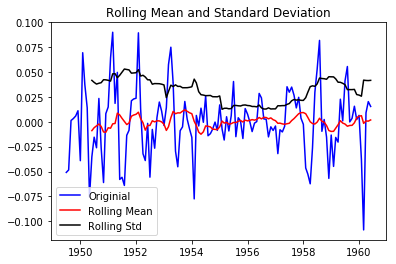

In [42]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace = True)
test_stationarity(ts_log_decompose)

#### Parameter ARIMA forecasting
* Jumlah AR (Auto-Regressive) term atau dikenal dgn "p": AR terms sama seperti lags dari variabel dependent. Misal p=5, maka prediktor untuk x(t) adalah x(t-1)...x(t-5)
* Jumlah MA (Moving Average) term atau dikenal dgn "q": MA term sama seperti forecast errors dalam prediksi. Misal q=5, maka prediktor x(t) adalah e(t-1)...e(t-5) dimana e(i) adalah selisih dari moving average pada posisi ke-i dengan nilai sebenarnya
* Number of difference atau dikenal dengan "d": jumlah nonseasonal differences.

Yang perlu diperhatikan adalah pemilihan nilai "p" dan "q". Kita bisa menggunakan dua plot yaitu ACF dan PACF plot.
* ACF: ACF adalah ukuran korelasi antara data dengan versi lagged data. Misal kita kasih lag=5, ACF akan membandingkan series pada waktu t1,...,t5 dengan series pada waktu t1-5,...,t5-5
* PACF: sama seperti ACF namun variasinya sudah dieliminasi terlebih dahulu

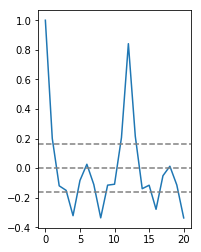

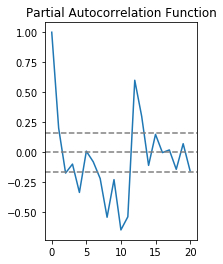

<Figure size 432x288 with 0 Axes>

In [46]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.show()
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
plt.tight_layout()

Garis putus-putus selain di titik 0 pada dua plot tersebut adalah selang kepercayaan. Ini digunakan untuk menentukan nilai 'p' dan 'q' values:
* p - nilai lag dimana grafik PACF melintasi selang kepercayaan atas untuk pertama kalinya
* q - nilai lag dimana grafik ACF melintasi selang kepercayaan atas untuk pertama kalinya 

### AR model

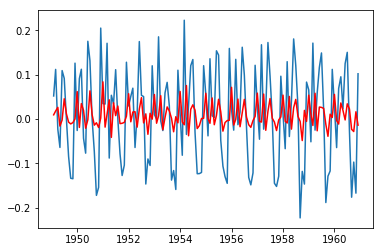

In [48]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 0), freq=ts_log.index.inferred_freq)
result_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.show()

### AR Model

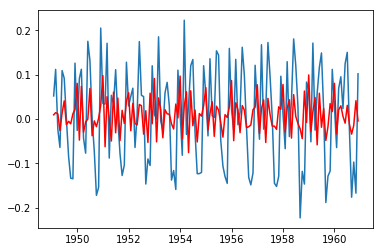

In [50]:

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(0, 1, 2), freq=ts_log.index.inferred_freq)  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.show()

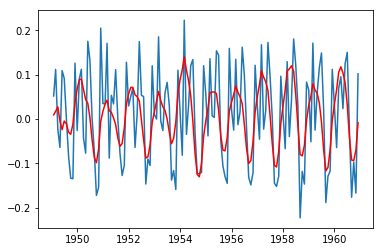

In [51]:
model = ARIMA(ts_log, order=(2, 1, 2), freq=ts_log.index.inferred_freq)  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()